# 4.2.1 BCT

In [1]:
import glob
import os
import re
import pickle
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
import bct
import seaborn as sns
import pandas as pd
import itertools
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def plot_efficiency_distribution(eff_df, network_type, atom_type):
    """Plot efficiency distribution boxplot with all x-axis labels right-aligned"""
    fig, ax = plt.subplots(figsize=(5, 4))
    palette = sns.color_palette("viridis", n_colors=10)
    
    # Ensure 'Rest' condition comes first
    if 'Condition' in eff_df.columns:
        condition_order = ['Rest'] + [c for c in eff_df['Condition'].unique() if c != 'Rest']
        eff_df['Condition'] = pd.Categorical(eff_df['Condition'], categories=condition_order, ordered=True)
        eff_df = eff_df.sort_values('Condition')
    
    # Calculate and print median values per condition
    median_values = eff_df.groupby('Condition')['Efficiency'].median()
    print("Median efficiency values per condition:")
    print(median_values)
    print("\n")
    
    sns.boxplot(
        data=eff_df, 
        x='Condition', 
        y='Efficiency',
        palette=palette,
        width=0.6,
        showfliers=False,
        ax=ax
    )
    sns.stripplot(
        data=eff_df,
        x='Condition',
        y='Efficiency',
        color='black',
        alpha=0.3,
        size=4,
        jitter=True,
        ax=ax
    )
    
    # ax.set_ylabel("Global Efficiency")
    ax.set_xlabel("")
    
    # Right-align all x-axis tick labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    
    fig.savefig("efficiency_distribution.pdf", format='pdf', bbox_inches='tight')
    return fig

In [3]:
def plot_median_diff_heatmap(eff_df, conditions, network_type, atom_type, output_pdf='bct_median_diff_heatmap.pdf'):
    """Plot median condition difference heatmap"""
    # Calculate median efficiency per condition
    median_eff = eff_df.groupby('Condition')['Efficiency'].median()
    
    # Ensure "Rest" condition comes first
    if 'Rest' in conditions:
        rest_idx = conditions.index('Rest')
        conditions = [conditions[rest_idx]] + [cond for cond in conditions if cond != 'Rest']
        median_eff = median_eff[conditions]
    
    # Create difference matrix
    n_conds = len(conditions)
    diff_matrix = np.zeros((n_conds, n_conds))
    for i in range(n_conds):
        for j in range(n_conds):
            diff_matrix[i,j] = median_eff[i] - median_eff[j]
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    diff_df = pd.DataFrame(
        diff_matrix * 100,  # Multiply by 100
        index=conditions,
        columns=conditions
    )
    
    # Create annotation matrix
    annot_matrix = np.empty_like(diff_matrix, dtype=object)
    for i in range(n_conds):
        for j in range(n_conds):
            if i == j:
                annot_matrix[i,j] = ''
            else:
                value = diff_matrix[i,j] * 100  # Convert to x10^-2
                annot_matrix[i,j] = f"{value:.2f}"
    
    # Plot heatmap - note vmin/vmax also multiplied by 100
    heatmap = sns.heatmap(
        diff_df,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        center=0,
        vmin=-np.max(np.abs(diff_matrix)) * 100,  # Multiplied by 100
        vmax=np.max(np.abs(diff_matrix)) * 100,   # Multiplied by 100
        cbar_kws={
            'label': 'Median Efficiency Difference (×10^-2)',
            'format': '%0.1f'  # Colorbar with 1 decimal
        },
        ax=ax
    )

    # Rotate x-axis labels 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()

    fig.savefig('bct_median_diff_heatmap.pdf', format='pdf', bbox_inches='tight')
    return fig

In [4]:
def plot_pvalue_heatmap(pval_matrix_fdr, conditions, network_type, atom_type):
    """Plot p-value heatmap with FDR correction"""
    # Ensure "Rest" condition comes first
    if 'Rest' in conditions:
        rest_idx = conditions.index('Rest')
        conditions = [conditions[rest_idx]] + [cond for cond in conditions if cond != 'Rest']
        pval_matrix_fdr = pval_matrix_fdr[np.ix_([rest_idx] + [i for i in range(len(conditions)) if i != rest_idx], 
                                               [rest_idx] + [i for i in range(len(conditions)) if i != rest_idx])]
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Convert to -log10(p)
    log_p_matrix = -np.log10(pval_matrix_fdr)
    log_p_df = pd.DataFrame(
        log_p_matrix, 
        index=conditions, 
        columns=conditions
    )
    
    # Create mask for non-significant regions
    mask = pval_matrix_fdr >= 0.05
    
    # Create annotation matrix (showing -log10(p) values)
    annot_matrix = np.empty_like(pval_matrix_fdr, dtype=object)
    for i in range(len(conditions)):
        for j in range(len(conditions)):
            if i == j:
                annot_matrix[i,j] = ''
            else:
                p = pval_matrix_fdr[i,j]
                if p < 0.05:
                    annot_matrix[i,j] = f"{log_p_matrix[i,j]:.2f}"
                else:
                    annot_matrix[i,j] = f"{log_p_matrix[i,j]:.2f}"  # Still show value but with gray background
    
    # Plot significant heatmap
    sns.heatmap(
        log_p_df,
        annot=annot_matrix,
        fmt='',
        cmap='YlOrRd',
        vmin=0,
        vmax=-np.log10(0.001),  # Corresponds to p=0.001
        cbar_kws={'label': '-log10(FDR-corrected p-value)'},
        ax=ax,
        mask=mask
    )
    
    # Add gray background for non-significant regions
    sns.heatmap(
        log_p_df,
        annot=annot_matrix,
        fmt='',
        cmap=['lightgray'],
        vmin=0,
        vmax=1,
        cbar=False,
        ax=ax,
        mask=~mask
    )
    
    # Rotate x-axis labels 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    fig.savefig("pvalue_heatmap.pdf", format='pdf', bbox_inches='tight')
    return fig

In [5]:
def plot_effect_size_heatmap(effect_size_matrix, conditions, network_type, atom_type, pval_matrix_fdr=None):
    """Plot effect size heatmap with optional significance masking"""
    # Ensure "Rest" condition comes first
    if 'Rest' in conditions:
        rest_idx = conditions.index('Rest')
        conditions = [conditions[rest_idx]] + [cond for cond in conditions if cond != 'Rest']
        effect_size_matrix = effect_size_matrix[np.ix_([rest_idx] + [i for i in range(len(conditions)) if i != rest_idx], 
                                                     [rest_idx] + [i for i in range(len(conditions)) if i != rest_idx])]
        if pval_matrix_fdr is not None:
            pval_matrix_fdr = pval_matrix_fdr[np.ix_([rest_idx] + [i for i in range(len(conditions)) if i != rest_idx], 
                                                    [rest_idx] + [i for i in range(len(conditions)) if i != rest_idx])]
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    effect_df = pd.DataFrame(
        effect_size_matrix,
        index=conditions,
        columns=conditions
    )
    
    # Create mask - diagonal or non-significant regions
    mask = np.zeros_like(effect_size_matrix, dtype=bool)
    np.fill_diagonal(mask, True)  # Mask diagonal
    
    if pval_matrix_fdr is not None:
        # Add non-significant regions to mask
        mask = mask | (pval_matrix_fdr >= 0.05)
    
    # Prepare annotation text
    annot_matrix = np.empty_like(effect_size_matrix, dtype=object)
    for i in range(len(conditions)):
        for j in range(len(conditions)):
            if i == j:
                annot_matrix[i,j] = ''
            else:
                annot_matrix[i,j] = f"{effect_size_matrix[i,j]:.2f}"
    
    # Plot main heatmap (significant regions)
    sns.heatmap(
        effect_df,
        annot=annot_matrix,
        fmt='',
        cmap='coolwarm',
        center=0,
        vmin=-2,
        vmax=2,
        cbar_kws={'label': "Cohen's d"},
        ax=ax,
        mask=mask
    )
    
    # Plot gray background for non-significant regions
    sns.heatmap(
        effect_df,
        annot=annot_matrix,
        fmt='',
        cmap=['lightgray'],
        center=0,
        vmin=-2,
        vmax=2,
        cbar=False,
        ax=ax,
        mask=~mask
    )
    
    # Rotate x-axis labels 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()

    fig.savefig("effect_size_heatmap.pdf", format='pdf', bbox_inches='tight')
    
    return fig

In [6]:
def analyze_trial_efficiencies(results_dir='results', network_type='TE', atom_type='xty'):
    """
    Main analysis function that returns statistical results and three plot objects
    
    Args:
        results_dir: Directory containing result files
        network_type: Network type ('TE', 'PhiID', 'PID')
        atom_type: Atom type (used when network_type is 'PhiID' or 'PID')
    """
    # Collect efficiency data for all conditions
    efficiency_data = defaultdict(list)
    result_files = glob.glob(os.path.join(results_dir, '*.pkl'))
    
    for filepath in sorted(result_files):
        try:
            with open(filepath, 'rb') as f:
                file_results = pickle.load(f)
            
            # Extract condition name from filename
            filename = os.path.basename(filepath)
            cond_match = re.search(r'results_(.*?)\.pkl', filename)
            cond = cond_match.group(1) if cond_match else filename.replace('.pkl', '')
            
            # Get ROI information
            roi_names = file_results.get('metadata', {}).get('roi_names', [])
            n_rois = len(roi_names)
            if n_rois == 0:
                print(f"No ROI names found in {filename}")
                continue
            
            trial_matrices = []
            
            # Process each condition in the file
            for cond_key, cond_data in file_results.get('conditions', {}).items():
                n_trials = None
                
                # Determine number of trials
                for pair_key, pair_data in cond_data.get('roi_pairs', {}).items():
                    if 'error' in pair_data:
                        continue
                    
                    # Get trial values based on network type
                    if network_type == 'TE':
                        trial_values = pair_data.get('TE', {}).get('values', [])
                    elif network_type == 'PhiID':
                        trial_values = pair_data.get('PhiID', {}).get('trial_values', {}).get(atom_type, [])
                    elif network_type == 'PID':
                        trial_values = pair_data.get('PID', {}).get('trial_values', {}).get(atom_type, [])
                    else:
                        trial_values = []
                    
                    # Ensure trial_values is a flat list of numbers
                    if isinstance(trial_values, (list, np.ndarray)) and len(trial_values) > 0:
                        if hasattr(trial_values[0], '__len__') and not isinstance(trial_values[0], str):
                            trial_values = [val[0] if hasattr(val, '__len__') else val for val in trial_values]
                    
                    # Initialize trial matrices
                    if n_trials is None and trial_values:
                        n_trials = len(trial_values)
                        trial_matrices = [np.zeros((n_rois, n_rois)) for _ in range(n_trials)]
                    
                    # Populate trial matrices
                    if n_trials is not None:
                        src, tgt = pair_data['roi_info']['indices']
                        for trial_idx, val in enumerate(trial_values):
                            if trial_idx < n_trials:
                                if hasattr(val, '__len__') and not isinstance(val, str):
                                    val = val[0]
                                trial_matrices[trial_idx][src, tgt] = float(val) if val is not None else 0.0
            
            # Calculate efficiency for each trial
            for mat in trial_matrices:
                try:
                    mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)
                    eff = bct.efficiency_wei(mat)
                    efficiency_data[cond].append(eff)
                except Exception as e:
                    print(f"Error calculating efficiency for {cond}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"Error processing file {os.path.basename(filepath)}: {str(e)}")
            continue
    
    if not efficiency_data:
        print("No efficiency data found!")
        return None, None, None, None
    
    # Convert to DataFrame
    eff_list = []
    for cond, effs in efficiency_data.items():
        for eff in effs:
            eff_list.append({'Condition': cond, 'Efficiency': eff})
    eff_df = pd.DataFrame(eff_list)
    
    # Calculate descriptive statistics
    condition_stats = eff_df.groupby('Condition')['Efficiency'].agg(['mean', 'median', 'std', 'count'])
    
    # Perform pairwise comparisons
    conditions = sorted(efficiency_data.keys())
    n_conds = len(conditions)
    
    pval_matrix = np.ones((n_conds, n_conds))
    effect_size_matrix = np.zeros((n_conds, n_conds))
    
    for i, j in itertools.combinations(range(n_conds), 2):
        cond1, cond2 = conditions[i], conditions[j]
        data1 = efficiency_data[cond1]
        data2 = efficiency_data[cond2]
        
        if len(data1) > 0 and len(data2) > 0:
            try:
                u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                pval_matrix[i, j] = p_val
                pval_matrix[j, i] = p_val
                
                pooled_std = np.sqrt(((len(data1)-1)*np.std(data1)**2 + (len(data2)-1)*np.std(data2)**2) / 
                                (len(data1) + len(data2) - 2))
                effect_size = (np.mean(data1) - np.mean(data2)) / pooled_std
                effect_size_matrix[i, j] = effect_size
                effect_size_matrix[j, i] = -effect_size
            except Exception as e:
                print(f"Error comparing {cond1} vs {cond2}: {str(e)}")
    
    # FDR correction
    pvals = pval_matrix[np.triu_indices_from(pval_matrix, k=1)]
    if len(pvals) > 0:
        _, pvals_fdr = fdrcorrection(pvals)
        pval_matrix_fdr = np.copy(pval_matrix)
        pval_matrix_fdr[np.triu_indices_from(pval_matrix_fdr, k=1)] = pvals_fdr
        pval_matrix_fdr[np.tril_indices_from(pval_matrix_fdr, k=-1)] = pvals_fdr
    else:
        pval_matrix_fdr = pval_matrix
    
    # Generate plots
    plot_efficiency_distribution(eff_df, network_type, atom_type)
    plot_median_diff_heatmap(eff_df, conditions, network_type, atom_type)
    plot_pvalue_heatmap(pval_matrix_fdr, conditions, network_type, atom_type)
    plot_effect_size_heatmap(effect_size_matrix, conditions, network_type, atom_type)
    
    # Return results and figures
    stats_results = {
        'condition_stats': condition_stats,
        'pairwise_pvals': pval_matrix,
        'pairwise_pvals_fdr': pval_matrix_fdr,
        'effect_sizes': effect_size_matrix,
        'network_type': network_type,
        'atom_type': atom_type,
        'efficiency_data': efficiency_data
    }
    
    return stats_results

/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_41626/1955033099.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values = eff_df.groupby('Condition')['Efficiency'].median()
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_41626/1955033099.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_41626/2612855518.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_eff 

Median efficiency values per condition:
Condition
Rest                  0.116759
AUD (L)               0.078916
MOp (L)               0.075323
MOs (R)               0.089771
RSPd_v (Bilateral)    0.076446
SSp-bfd (L)           0.083553
SSp-ul_ll (R)         0.077421
VISa_rl (R)           0.084085
VISam_pm (R)          0.083459
VISp (L)              0.078704
Name: Efficiency, dtype: float64




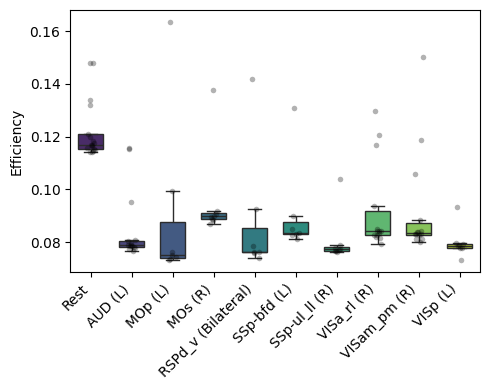

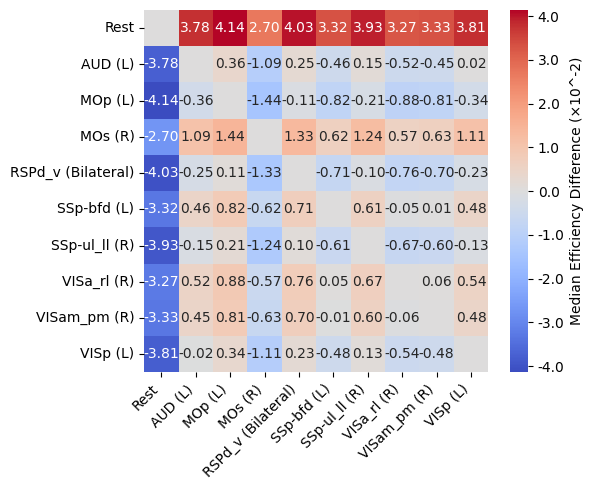

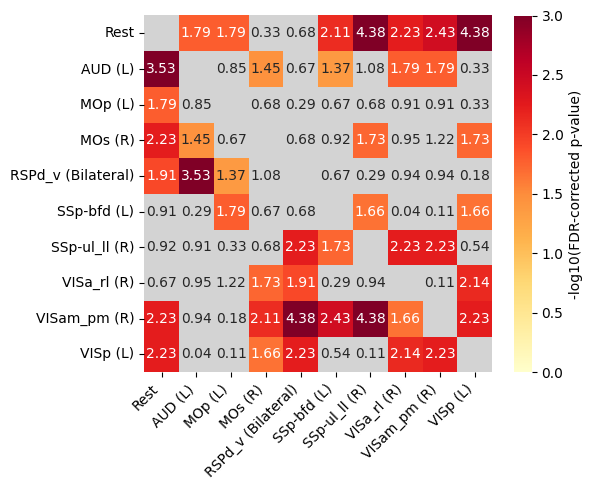

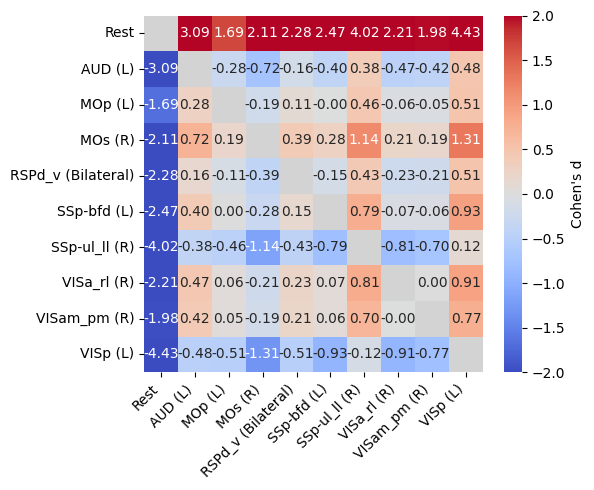

In [7]:
stats_results = analyze_trial_efficiencies(results_dir='results', network_type='TE')

with open("efficiency_stats.pkl", 'wb') as f:
    pickle.dump(stats_results, f)